# Social Doors Cerebellum PPI Analysis

Author: Haroon Popal 


## Set Up

In [25]:
import glob
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns

from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.second_level import make_second_level_design_matrix, SecondLevelModel
from nilearn.image import load_img, smooth_img, binarize_img, resample_to_img
from nilearn.plotting import plot_glass_brain, plot_design_matrix
from nilearn.maskers import NiftiMasker
from nilearn.masking import apply_mask
from nilearn.glm import threshold_stats_img


import matplotlib.pyplot as plt

import importlib

import helpful_functions
importlib.reload(helpful_functions)


import warnings
warnings.filterwarnings('ignore')

### Set Paths

In [2]:
bids_dir = '/Users/haroonpopal/OneDrive - Temple University/olson_lab/projects/social_doors/'
os.chdir(bids_dir)

outp_dir = os.path.join(bids_dir, 'derivatives', 'ppi_analysis-nilearn')
data_dir = os.path.join(bids_dir, 'derivatives','social_doors-nilearn')

if os.path.exists(outp_dir):
    print('Output directory already exists. Continuing will overwrite data.')
else:
    os.makedirs(outp_dir)

Output directory already exists. Continuing will overwrite data.


### Import participant list

In [10]:
subjs_scan_info = pd.read_csv(bids_dir+'derivatives/participants_good.tsv', sep='\t', index_col=0)

subjs_list = list(subjs_scan_info['participant_id'].unique())
len(subjs_list)

# Remove bad participant
subjs_list = [x for x in subjs_list if x != 'sub-4069']
subjs_list = [x for x in subjs_list if x != 'sub-3880']
subjs_list = [x for x in subjs_list if x != 'sub-5082']

subjs_list.sort()
print('Found '+str(len(subjs_list))+' subjects')
subj = subjs_list[0]

Found 60 subjects


In [11]:
subjs_scan_info.head()

,participant_id,age,sex,group
0,sub-010,13,F,kid
2,sub-013,13,M,kid
5,sub-028,15,M,kid
6,sub-036,16,F,kid
7,sub-5049,12,F,kid


### Import MRI quality control info

In [5]:
qc_summary = pd.read_csv('derivatives/qc_summary.csv')

# Filter qc summary for only good participants
qc_summary_good = qc_summary[qc_summary['subject'].isin(subjs_list)]
qc_summary_good.head()

,subject,run,rating,artifacts
0,sub-010,mdoors_run-1,4,[]
1,sub-010,mdoors_run-2,3,['head-motion']
2,sub-010,social_run-1,4,[]
3,sub-010,social_run-2,4,[]
8,sub-013,mdoors_run-1,3,"['head-motion','parietal-cutoff']"


# Single Subject Analysis
This will complete the PPI analysis for a single subject to explain each step of the process, before running for all participants

## Set up task info

In [57]:
task = 'social'

func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
func_run_names = func_run_names['run'].to_list()

In [58]:
tr = 2.1
n_tr = 130

# Slice time correction to middle of TR
slice_time_ref = 0.5

## Find functional data

In [59]:
# Find functinoal runs that passed quality control
func_runs = []
for run in func_run_names:
    func_runs.append(glob.glob(os.path.join(bids_dir, 'derivatives', 'fmriprep', subj, 'func',
                                   subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))[0])
func_runs.sort()
    
# Set a grey matter mask
subj_gm_mask = 'derivatives/fmriprep/'+subj+'/anat/'+subj+'_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'


In [60]:
## Find the task event files that are ready to become design matrices
#design_mtx_files = [f for f in glob.glob(os.path.join(bids_dir, 'derivatives', 'ppi_analysis-nilearn', 
#                                                      'design_matrices', 
#                                                      subj+'_task-'+task+'_run-*_desc-design_matrix.csv'), 
#                                                      recursive=True)]
#design_mtx_files.sort()

In [61]:
cond_interest = ['positive_win', 'positive_loss',
                 'negative_win', 'negative_loss']

In [62]:
## Find the task event files that are ready to become design matrices
event_files = [f for f in glob.glob(os.path.join(bids_dir, 'Nifti', subj, 
                                                 'func', 
                                                 subj+'_task-'+task+'_run-*_events.tsv'), 
                                    recursive=True)]
event_files.sort()


events_data = []

for n in range(len(event_files)):
    events = pd.read_csv(event_files[n], sep='\t')

    # Rename trial types for all wins and all losses
    events['trial_type'] = events['trial_type'].replace(['positive_win', 'negative_win'], 'all_win')
    events['trial_type'] = events['trial_type'].replace(['positive_loss', 'negative_loss'], 'all_loss')
    
    events_data.append(events)

events.head()

,onset,duration,trial_type
0,5.039,0.6,fixation
1,5.639,3.0,negative
2,8.638,0.6,fixation
3,9.237,1.0,all_win
4,10.250,3.2,fixation


In [63]:
# Set path to subject specific fmriprep output
fmri_run_data_dir = bids_dir+'derivatives/fmriprep/'+subj+'/func/'

In [64]:
# Set motion parameters to regress out
confound_reg_names = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z',
                      'white_matter','csf']

In [65]:
confound_files = [f for f in glob.glob(fmri_run_data_dir + subj+'_task-'+task+'_run-*_desc-confounds_timeseries'+'.tsv', recursive=True)]
confound_files.sort()

In [66]:
confounds = []

for c_file in confound_files:
    motion_reg = pd.read_csv(c_file, sep='\t')

    # Fill na values
    motion_reg = motion_reg.fillna(0)

    # Filter for just the motion regressors specified above and add to a 
    # general confounds list
    confounds.append(motion_reg[confound_reg_names])

In [67]:
start_time = slice_time_ref * tr
end_time = (n_tr - 1 + slice_time_ref) * tr
frame_times = np.linspace(start_time, end_time, n_tr)

In [68]:
events_data[1]

,onset,duration,trial_type
0,5.039,0.6,fixation
1,5.639,3.0,negative
2,8.638,0.6,fixation
3,9.237,1.0,all_win
4,10.250,3.2,fixation
...,...,...,...
145,262.042,0.6,fixation
146,262.642,3.0,positive
147,265.641,0.6,fixation
148,266.240,1.0,all_win


In [69]:
# Make design matrix
design_matrix = make_first_level_design_matrix(frame_times, 
                                               events_data[0], 
                                               hrf_model='spm',
                                               drift_model='polynomial',
                                               high_pass=0.01,
                                               add_regs=confounds[0],
                                               add_reg_names=confounds[0].columns.tolist())

In [70]:
# Drop irrelevant regressors
design_matrix = design_matrix.drop(['fixation', 'negative', 'positive'], axis=1)

<AxesSubplot:>

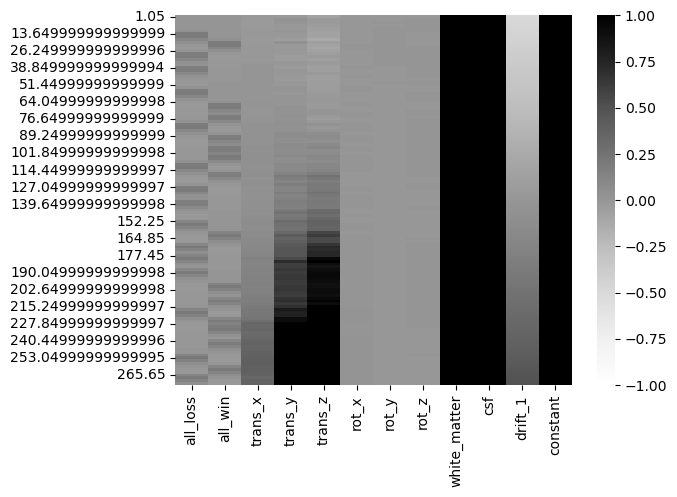

In [71]:
sns.heatmap(design_matrix, cmap='Greys', vmin=-1, vmax=1)

## Set an ROI
The region of interest (ROI) used here is "region 8" from the MDTB cerebellum atlas from [King et al., 2019](https://www.nature.com/articles/s41593-019-0436-x).

In [72]:
roi_names = ['region08']

rois_dict = {}

for n in range(len(roi_names)):
    roi_path = glob.glob(os.path.join(bids_dir, 'derivatives','rois',
                                                    'mdtb_'+roi_names[n]+'.nii.gz'))
    rois_dict[roi_names[n]] = load_img(roi_path)

### Import networks of interest
For this analysis, we will examine the connectivity of the cerebellum to a social brain network and the reward network, as defined by neurosynth.

#### Social Network

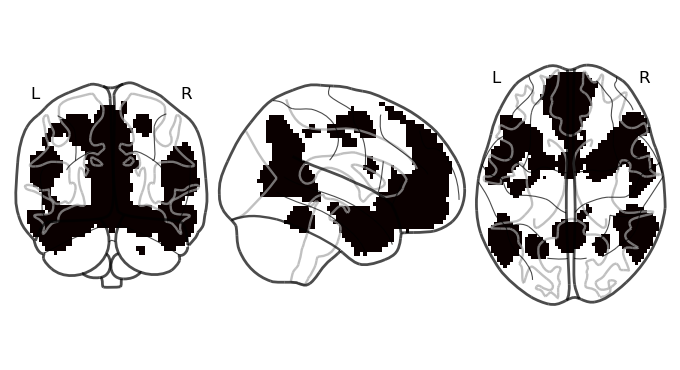

In [90]:
# Load ROI
social_net = load_img(os.path.join(bids_dir, 'derivatives','nimare', 
                                     'neurosynth_term-social_z_desc-association.nii.gz'))

# Resample to match fmri data space (which is the same as this ROI)
social_net = resample_to_img(social_net, target_img=rois_dict['region08'])

# Smooth
social_net_sm = smooth_img(social_net, fwhm=4)

# Mask out the cerebellum
cb_mask = load_img(os.path.join(bids_dir, 'derivatives', 'social_doors-nilearn', 
                                  subj, 'suit', 'iw_c_sub-010_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w_pcereb_u_a_sub-010_run-1_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'))

# Remove cerebellum regions
social_net_sm.dataobj[:][cb_mask.dataobj[:] > 0] = 0

# Smooth
#social_net_sm = smooth_img(social_net.to_nifti(), 4)

# Filter for Z-score equivalent to p = .001
social_net_sm_bin = binarize_img(social_net_sm, threshold=4)

plot_glass_brain(social_net_sm_bin)

#### Reward Network

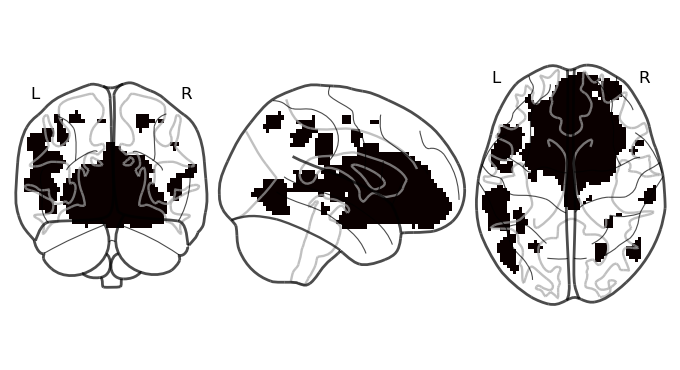

In [91]:
reward_net = load_img(os.path.join(bids_dir, 'derivatives','nimare', 
                                     'neurosynth_term-reward_z_desc-association.nii.gz'))

# Resample to match fmri data space (which is the same as this ROI)
reward_net = resample_to_img(reward_net, target_img=rois_dict['region08'])

# Smooth
reward_net_sm = smooth_img(reward_net, fwhm=4)

# Mask out the cerebellum
cb_mask = load_img(os.path.join(bids_dir, 'derivatives', 'social_doors-nilearn', 
                                  subj, 'suit', 'iw_c_sub-010_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w_pcereb_u_a_sub-010_run-1_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'))

# Remove cerebellum regions
reward_net_sm.dataobj[:][cb_mask.dataobj[:] > 0] = 0

# Filter for Z-score equivalent to p = .001
reward_net_sm_bin = binarize_img(reward_net_sm, threshold=4)

plot_glass_brain(reward_net_sm_bin)

## Extract Data

Text(0.5, 0, 'Time (TRs)')

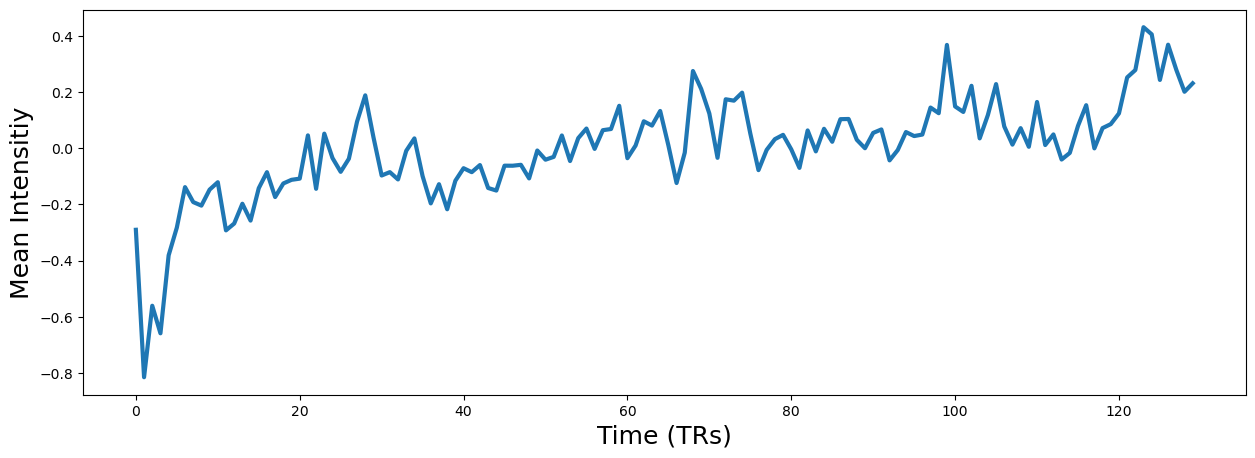

In [92]:
# Load a nifti image as a mask
seed_mask = NiftiMasker(mask_img=rois_dict['region08'], standardize='zscore')

# Extract the time series of each voxel within the mask
seed_data = seed_mask.fit_transform(func_runs[0])

# Average across voxels for the mean time series of the ROI
seed_data_mean = seed_data.mean(axis=1)

# Plot mean time series
plt.figure(figsize=(15,5))
plt.plot(seed_data_mean, linewidth=3)
plt.ylabel('Mean Intensitiy', fontsize=18)
plt.xlabel('Time (TRs)', fontsize=18)

## Create design matrix

In [93]:
func_run_names

['mdoors_run-1', 'mdoors_run-2']

## Psychophysiological Interaction Analysis

### Add region x condition interaction terms
For this analysis we will use a generalized PPI framework in which we take the interaction of each condition of interest with the time series of an ROI

<AxesSubplot:>

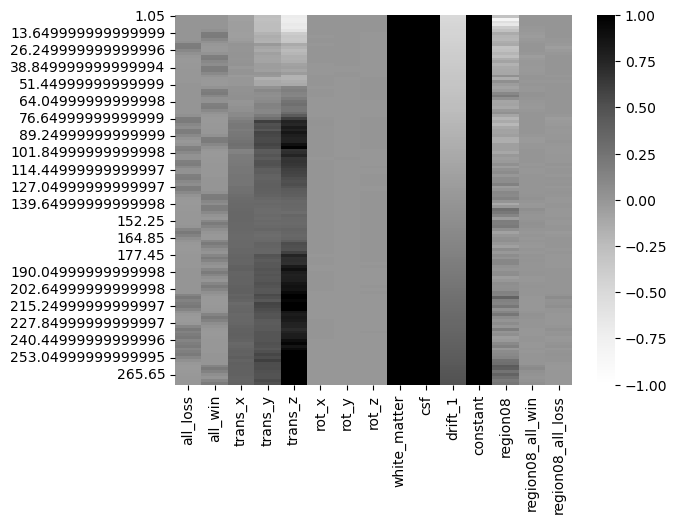

In [94]:
# Add ROI time series
design_matrix['region08'] = seed_data_mean


# Create generalized interaction terms
design_matrix['region08_all_win'] = design_matrix['region08']*design_matrix['all_win']
design_matrix['region08_all_loss'] = design_matrix['region08']*design_matrix['all_loss']


sns.heatmap(design_matrix, cmap='Greys', vmin=-1, vmax=1)

### Regress onto the whole brain

In [95]:
ppi_glm = FirstLevelModel(mask_img=subj_gm_mask,
                         t_r=tr,
                         slice_time_ref=slice_time_ref,
                         noise_model='ar1',
                         standardize=False,
                         hrf_model='spm',
                         high_pass=0.01)

ppi_glm = ppi_glm.fit(func_runs[0], design_matrices=design_matrix)

In [96]:
ppi_glm.design_matrices_[0].columns

Index(['all_loss', 'all_win', 'trans_x', 'trans_y', 'trans_z', 'rot_x',
       'rot_y', 'rot_z', 'white_matter', 'csf', 'drift_1', 'constant',
       'region08', 'region08_all_win', 'region08_all_loss'],
      dtype='object')

In [97]:
cond_a_list = ['region08_all_win']
cond_b_list = ['region08_all_loss']
contrasts_df = pd.DataFrame(list(zip(cond_a_list, cond_b_list)), 
                            columns=['cond_a','cond_b'])

# Create a dictionary that will store the contrast arrays
contrasts_bw_conds = {}

dm_cols = list(ppi_glm.design_matrices_[0].columns)

# Loop through and fill in 1s and 0s for contrasts
for n in range(len(contrasts_df)):
    # Find the condition names to be contrasted
    cond_a = contrasts_df.loc[n,'cond_a']
    cond_b = contrasts_df.loc[n,'cond_b']
    
    # Create an array of zeros
    contrasts_bw_conds[cond_a+'_V_'+cond_b] = np.zeros(len(dm_cols))
    
    # Find the index of each condtion as defined before
    temp_idx_a = dm_cols.index(cond_a)
    temp_idx_b = dm_cols.index(cond_b)
    
    # Fill the exact condition index in the contrast array with a 1 or -1
    contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_a] = 1
    contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_b] = -1

contrasts_bw_conds

{'region08_all_win_V_region08_all_loss': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1., -1.])}

<AxesSubplot:label='conditions'>

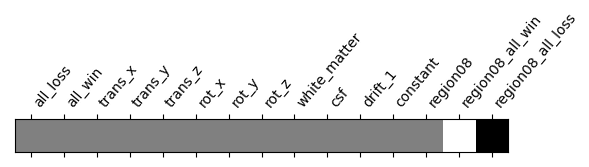

In [98]:
from nilearn.plotting import plot_contrast_matrix

plot_contrast_matrix(contrasts_bw_conds['region08_all_win_V_region08_all_loss'], design_matrix=design_matrix)

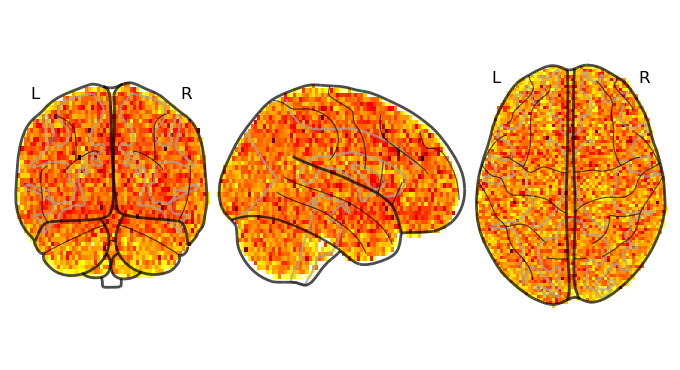

In [99]:
z_map = ppi_glm.compute_contrast(contrasts_bw_conds['region08_all_win_V_region08_all_loss'], 
                                 output_type='z_score')

plot_glass_brain(z_map)

In [100]:
social_net_mask = NiftiMasker(mask_img=social_net_sm_bin)

# Extract the time series of each voxel within the mask
z_map_social_net = social_net_mask.fit_transform(z_map)

z_map_social_net[0].mean()

-0.1290673589200934

# Group PPI Analysis

In [101]:
seed = 'region08'
fwhm=6

tasks = ['mdoors', 'social']
network_rois = ['reward', 'social']

network_masks = {}
network_masks['reward'] = reward_net_sm_bin
network_masks['social'] = social_net_sm_bin

Calculating PPI for sub-010
Number of functional runs for sub-010: 2
Number of functional runs for sub-010: 2
Calculating PPI for sub-013
Number of functional runs for sub-013: 2
Number of functional runs for sub-013: 2
Calculating PPI for sub-028
Number of functional runs for sub-028: 2
Number of functional runs for sub-028: 2
Calculating PPI for sub-036
Number of functional runs for sub-036: 2
Number of functional runs for sub-036: 2
Calculating PPI for sub-3845
Number of functional runs for sub-3845: 2
Number of functional runs for sub-3845: 2
Calculating PPI for sub-3846
Number of functional runs for sub-3846: 2
Number of functional runs for sub-3846: 2
Calculating PPI for sub-3848
Number of functional runs for sub-3848: 2
Number of functional runs for sub-3848: 2
Calculating PPI for sub-3849
Number of functional runs for sub-3849: 2
Number of functional runs for sub-3849: 2
Calculating PPI for sub-3852
Number of functional runs for sub-3852: 2
Number of functional runs for sub-385

ValueError: left cannot be >= right

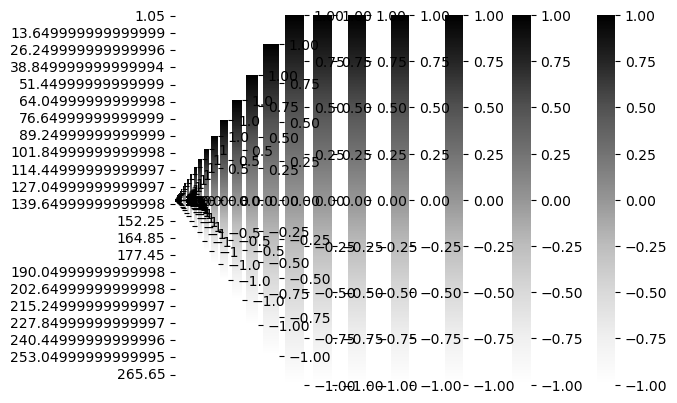

In [102]:
ppi_roi_stats = pd.DataFrame(columns=['subject_id','seed','task','roi','mean'])


for subj in qc_summary_good['subject'].unique():
    print('Calculating PPI for '+subj)
    
    # Set path to subject specific fmriprep output
    fmri_run_data_dir = bids_dir+'derivatives/fmriprep/'+subj+'/func/'
    
    # Create subject output directory
    outp_dir_subj = outp_dir+'/'+subj
    #if not os.path.exists(outp_dir_subj):
    #    os.makedirs(outp_dir_subj)
    #else:
    #    continue
    
    for task in tasks:
        # Import functional runs that passed quality control
        func_run_names = qc_summary[(qc_summary['subject'] == subj) & (qc_summary['run'].str.contains(task))]
        func_run_names = func_run_names['run'].to_list()
        func_run_names.sort()

        print('Number of functional runs for '+subj+': '+str(len(func_run_names)))
        
        
        # Create PPI design matrix for each run
        func_runs = []
        event_files = []
        events_data = []
        confound_files = []
        confounds_data = []
        design_matrices = []

        for n in range(len(func_run_names)):
            # Set run prefix name
            run = func_run_names[n]
            
            # Find functional data
            func_runs.append(os.path.join(fmri_run_data_dir,
                                          subj+'_task-'+run+'_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))
            
            # Find task event files
            event_files.append(os.path.join(bids_dir, 'Nifti', subj, 'func',
                                            subj+'_task-'+run+'_events.tsv'))
            
            # Find confounds files
            confound_files.append(os.path.join(fmri_run_data_dir,
                                               subj+'_task-'+run+'_desc-confounds_timeseries.tsv'))                     
        
        
            # Load event data
            e_file = event_files[n]
            events = pd.read_csv(e_file, sep='\t')

            # Rename trial types for all wins and all losses
            events['trial_type'] = events['trial_type'].replace(['positive_win', 'negative_win'], 'all_win')
            events['trial_type'] = events['trial_type'].replace(['positive_loss', 'negative_loss'], 'all_loss')

            events_data.append(events)
        
        
            # Load confound data
            c_file = confound_files[n]
            motion_reg = pd.read_csv(c_file, sep='\t')

            # Fill na values
            motion_reg = motion_reg.fillna(0)

            # Filter for just the motion regressors specified above and add to a 
            # general confounds list
            confounds_data.append(motion_reg[confound_reg_names])
        
        
            # Set design matrix parameters
            start_time = slice_time_ref * tr
            end_time = (n_tr - 1 + slice_time_ref) * tr
            frame_times = np.linspace(start_time, end_time, n_tr)

            # Make design matrix
            design_matrix = make_first_level_design_matrix(frame_times, 
                                                       events_data[n], 
                                                       hrf_model='spm',
                                                       drift_model='polynomial',
                                                       high_pass=0.01,
                                                       add_regs=confounds[n],
                                                       add_reg_names=confounds[n].columns.tolist())
            
            # Drop irrelevant regressors
            design_matrix = design_matrix.drop(['fixation', 'negative', 'positive'], axis=1)
        
            
            # Extract the time series of each voxel within the seed mask
            seed_data = seed_mask.fit_transform(func_runs[n])

            # Average across voxels for the mean time series of the ROI
            seed_data_mean = seed_data.mean(axis=1)
            
            
            # Create PPI design matrix
            # Add ROI time series
            design_matrix[seed] = seed_data_mean


            # Create generalized interaction terms
            design_matrix[seed+'_all_win'] = design_matrix[seed]*design_matrix['all_win']
            design_matrix[seed+'_all_loss'] = design_matrix[seed]*design_matrix['all_loss']
            
            design_matrices.append(design_matrix)
            
            # Export design matrix
            design_matrix.to_csv(os.path.join(outp_dir_subj,subj+'_task-'+run+'_desc-design_matrix.csv'))
            
            # Save overall design matrix
            dm_plot = sns.heatmap(design_matrix, cmap='Greys', vmin=-1, vmax=1)
            plt.savefig(os.path.join(outp_dir_subj,subj+'_task-'+run+'_desc-design_matrix.png'))
        
        
        # Conduct PPI GLM
        ppi_glm = FirstLevelModel(mask_img=subj_gm_mask,
                                  t_r=tr,
                                  slice_time_ref=slice_time_ref,
                                  noise_model='ar1',
                                  standardize=False,
                                  hrf_model='spm',
                                  high_pass=0.01)

        ppi_glm = ppi_glm.fit(func_runs, design_matrices=design_matrices)
        
        # Create a dictionary that will store the contrast arrays
        contrasts_bw_conds = {}

        dm_cols = list(ppi_glm.design_matrices_[0].columns)

        # Loop through and fill in 1s and 0s for contrasts
        for n in range(len(contrasts_df)):
            # Find the condition names to be contrasted
            cond_a = contrasts_df.loc[n,'cond_a']
            cond_b = contrasts_df.loc[n,'cond_b']

            # Create an array of zeros
            contrasts_bw_conds[cond_a+'_V_'+cond_b] = np.zeros(len(dm_cols))

            # Find the index of each condtion as defined before
            temp_idx_a = dm_cols.index(cond_a)
            temp_idx_b = dm_cols.index(cond_b)

            # Fill the exact condition index in the contrast array with a 1 or -1
            contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_a] = 1
            contrasts_bw_conds[cond_a+'_V_'+cond_b][temp_idx_b] = -1
            
            cont_name = list(contrasts_bw_conds.keys())[n]
            
            # Regress
            z_map = ppi_glm.compute_contrast(contrasts_bw_conds[cont_name], 
                                             output_type='z_score')

            # Save whole brain PPI map
            z_map.to_filename(os.path.join(outp_dir_subj, 'zmap_task-'+task+'_'+cont_name+'.nii.gz'))
        
            # Extract the mean beta within each network mask
            for net_roi in network_rois:
                net_mask = NiftiMasker(mask_img=network_masks[net_roi])
                
                z_map_net = net_mask.fit_transform(z_map)

                temp_mean = z_map_net[0].mean()
                
                # Save data
                ppi_roi_stats.loc[len(ppi_roi_stats)] = [subj,seed,task,net_roi,temp_mean]
                ppi_roi_stats.to_csv(outp_dir+'/ppi_seed-'+seed+'network_roi_stats.csv', index=False)


# All Participants Group Average

In [59]:
ppi_roi_stats['mean']

0     0.312687
1     0.459966
2    -0.129165
3    -0.185046
4     0.001059
        ...   
91    0.060674
92    0.135666
93    0.025060
94    0.101057
95    0.102056
Name: mean, Length: 96, dtype: float64

In [60]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('mean ~ C(task) + C(roi) + C(task):C(roi)', 
            data=ppi_roi_stats).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(task),0.002146,1.0,0.050567,0.822579
C(roi),0.003840,1.0,0.090493,0.764231
C(task):C(roi),0.004021,1.0,0.094759,0.758908
Residual,3.903574,92.0,NaN,NaN


In [63]:
ppi_roi_stats.head()

,subject_id,seed,task,roi,mean
0,sub-5083,region08,mdoors,reward,0.312687
1,sub-5083,region08,mdoors,social,0.459966
2,sub-5083,region08,social,reward,-0.129165
3,sub-5083,region08,social,social,-0.185046
4,sub-5084,region08,mdoors,reward,0.001059


(array([0, 1]), [Text(0, 0, 'reward'), Text(1, 0, 'social')])

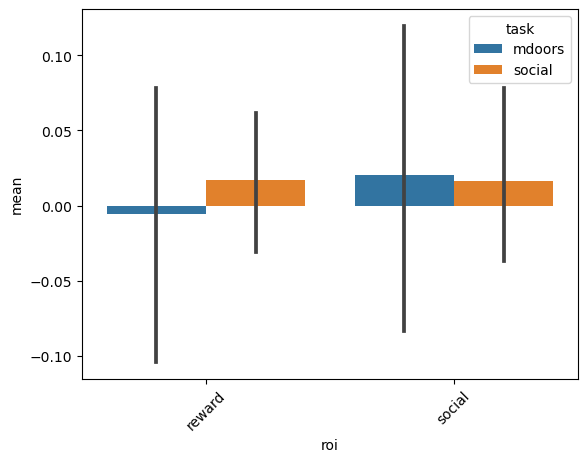

In [69]:
sns.barplot(data=ppi_roi_stats, x='roi', y='mean', hue='task')
plt.xticks(rotation=45)

## Young Adults

**Results:** No significant clusters, but a more liberal threshold shows more positive correlations between Crus I/II with vmPFC, dlPFC, and more negative correlation with the ventral stream for all wins than for all losses.

In [12]:
subjs_scan_info = subjs_scan_info[subjs_scan_info['participant_id'] != 'sub-4069']
subjs_scan_info = subjs_scan_info[subjs_scan_info['participant_id'] != 'sub-3880']

In [13]:
# Create list of young adult data
subjs_scan_info_adult = subjs_scan_info[subjs_scan_info['group'] == 'college']
print('There are ' + str(len(subjs_scan_info_adult))+ ' young adults')

file_list_adult_ppi = []

for subj in subjs_scan_info_adult['participant_id']:
    file_list_adult_ppi.append(glob.glob(os.path.join(outp_dir,
                                                      subj, 
                                                      'zmap_task-social_region08_all_win_V_region08_all_loss.nii.gz'))[0])


print('Found '+str(len(file_list_adult_ppi))+' subject maps')

There are 29 young adults
Found 29 subject maps


<AxesSubplot:label='conditions', ylabel='scan number'>

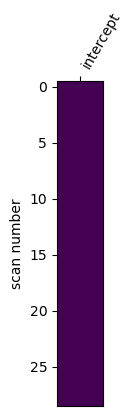

In [22]:
design_matrix = make_second_level_design_matrix(subjs_scan_info_adult['participant_id'])

plot_design_matrix(design_matrix)

In [26]:
mni_gm_mask = 'derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'

contrasts=['region08_all_win_V_region08_all_loss']
group = 'adult'
tasks = ['mdoors', 'social']
alpha = 0.05
mc = 'fdr'



for task in tasks:
    for contrast in contrasts:
        file_list_adult_ppi = []
        for subj in subjs_scan_info_adult['participant_id']:
            file_list_adult_ppi.append(glob.glob(os.path.join(outp_dir,
                                                          subj, 'zmap_task-'+task+'_'+contrast+'.nii.gz'))[0])

        print('Calculating PPI analysis for '+task+' '+contrast)
        
        design_matrix = make_second_level_design_matrix(subjs_scan_info_adult['participant_id'])
        model = SecondLevelModel(mask_img=mni_gm_mask, smoothing_fwhm=8.0)
        model.fit(file_list_adult_ppi, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_task-'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_task-'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

        z_map_thresh.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_task-'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
            


Calculating PPI analysis for mdoors region08_all_win_V_region08_all_loss
Calculating PPI analysis for social region08_all_win_V_region08_all_loss


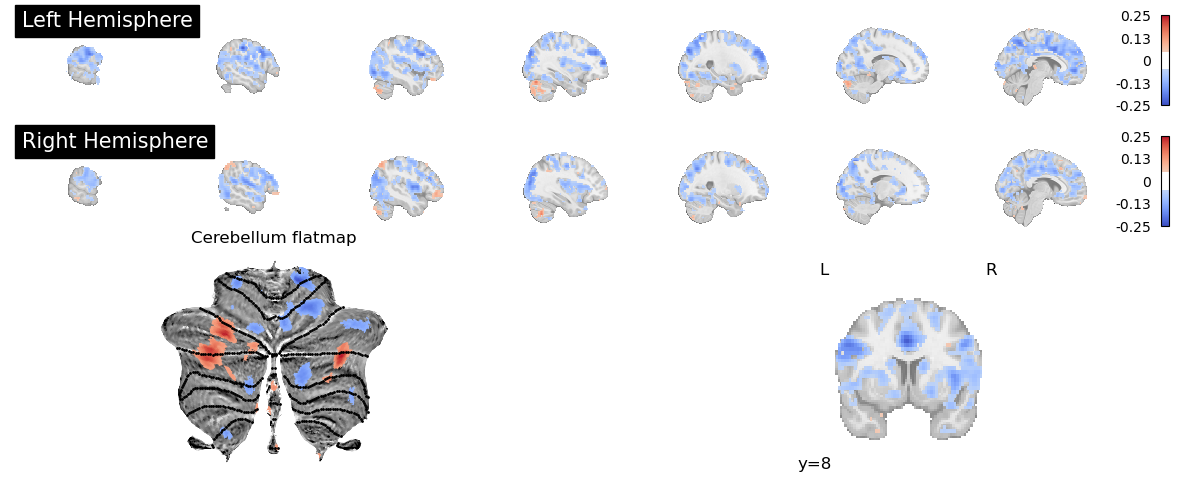

In [27]:
filename = outp_dir+'/group_results/'+'adult_ppi_task-mdoors_region08_all_win_V_region08_all_loss'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

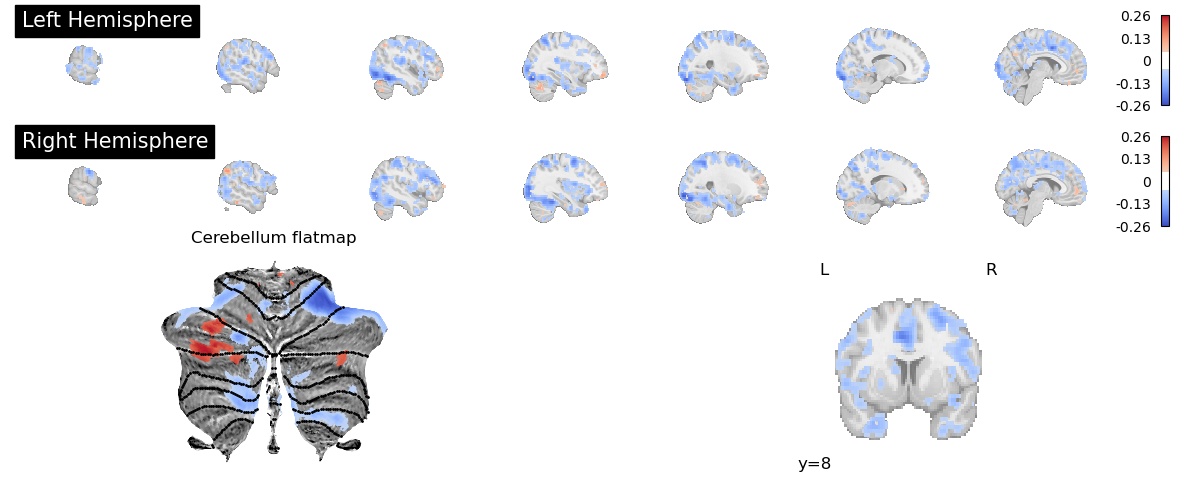

In [29]:
filename = outp_dir+'/group_results/'+'adult_ppi_task-social_region08_all_win_V_region08_all_loss'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

## Adolescents

In [34]:
subjs_scan_info = subjs_scan_info[subjs_scan_info['participant_id'] != 'sub-5082']


In [35]:
# Create list of adolescent data
subjs_scan_info_adole = subjs_scan_info[subjs_scan_info['group'] == 'kid']
print('There are ' + str(len(subjs_scan_info_adole))+ ' adolescents')

# Find PPI maps
file_list_adole_ppi = []

for subj in subjs_scan_info_adole['participant_id']:
    file_list_adole_ppi.append(glob.glob(os.path.join(outp_dir, subj,
                                                      'zmap_task-social_region08_all_win_V_region08_all_loss.nii.gz'))[0])


print('Found '+str(len(file_list_adole_ppi))+' subject maps')

There are 31 adolescents
Found 31 subject maps


<AxesSubplot:label='conditions', ylabel='scan number'>

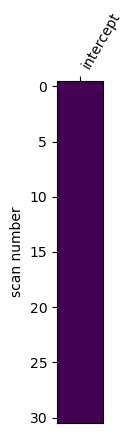

In [36]:
design_matrix = make_second_level_design_matrix(subjs_scan_info_adole['participant_id'])

plot_design_matrix(design_matrix)

In [38]:
mni_gm_mask = 'derivatives/fmriprep/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_label-GM_probseg_bin.nii.gz'

contrasts=['region08_all_win_V_region08_all_loss']
group = 'adole'
tasks = ['mdoors', 'social']
alpha = 0.05
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        file_list_adole_ppi = []
        for subj in subjs_scan_info_adole['participant_id']:
            file_list_adole_ppi.append(glob.glob(os.path.join(outp_dir,
                                                          subj, 'zmap_task-'+task+'_'+contrast+'.nii.gz'))[0])

        print('Calculating PPI analysis for '+task+' '+contrast)
        
        design_matrix = make_second_level_design_matrix(subjs_scan_info_adole['participant_id'])

        
        model = SecondLevelModel(mask_img=mni_gm_mask, smoothing_fwhm=8.0)
        model.fit(file_list_adole_ppi, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_task-'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_task-'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

        z_map_thresh.to_filename(os.path.join(outp_dir,'group_results',
                                   group+'_ppi_task-'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
            
        # Save mean for roi
        

Calculating PPI analysis for mdoors region08_all_win_V_region08_all_loss
Calculating PPI analysis for social region08_all_win_V_region08_all_loss


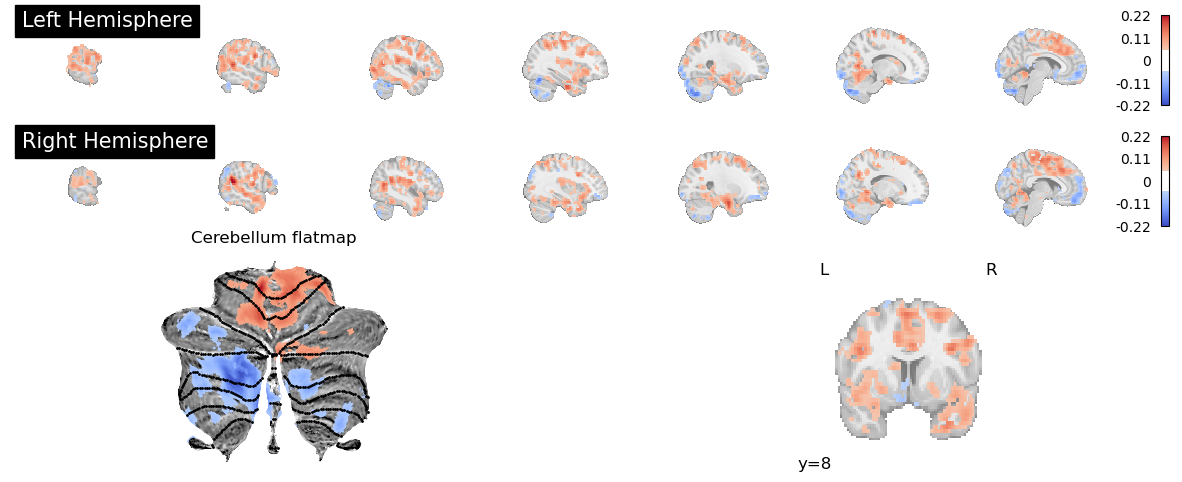

In [39]:
filename = outp_dir+'/group_results/'+'adole_ppi_task-mdoors_region08_all_win_V_region08_all_loss'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

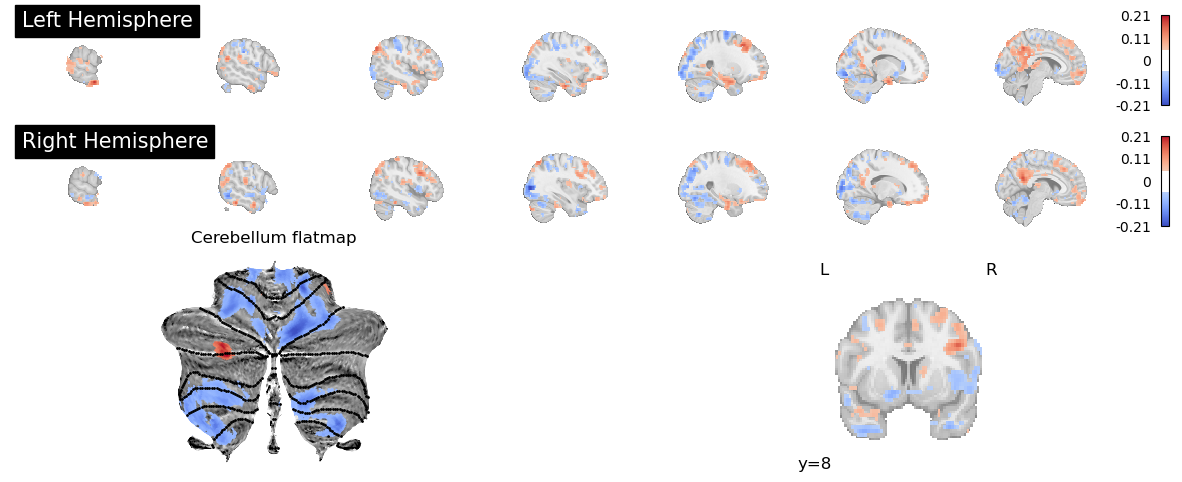

In [40]:
filename = outp_dir+'/group_results/'+'adole_ppi_task-social_region08_all_win_V_region08_all_loss'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

**Results:** No significant clusters. However, a liberal thershold shows greater positive correlations between Crus I/II and the frontal pole for all wins than for losses.

# Between Groups

## Second Level Design Matrix

<AxesSubplot:label='conditions', ylabel='scan number'>

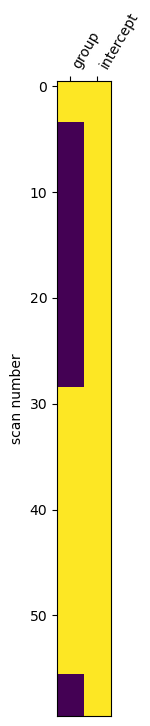

In [50]:
# Make a copy for the design matrix df
subjs_info_num = subjs_scan_info.copy()

# Remove bad subjects
subjs_info_num = subjs_info_num[subjs_info_num['participant_id'] != 'sub-4069']


# Turn values numeric
subjs_info_num = subjs_info_num.replace({'group': {'college': -1, 'kid': 1}})

# Remove irrelevant info
subjs_info_num = subjs_info_num.drop(columns=['age', 'sex'])

# Change column header for needed function input
subjs_info_num = subjs_info_num.rename({'participant_id':'subject_label'}, axis='columns')

design_matrix = make_second_level_design_matrix(subjs_list, subjs_info_num)

plot_design_matrix(design_matrix)

In [53]:
group = 'all'

# Find PPI data
file_list = []
for subj in subjs_list:
    file_list.append(glob.glob(os.path.join(outp_dir,
                                            subj, 'zmap_task-'+task+'_'+contrast+'.nii.gz'))[0])

# Create second level model
model = SecondLevelModel(mask_img=mni_gm_mask, smoothing_fwhm=8.0)
model.fit(file_list, design_matrix=design_matrix)
        
contrast_stats = model.compute_contrast('group',output_type='all')
z_map = contrast_stats['z_score']
e_map = contrast_stats['effect_size']

z_map.to_filename(os.path.join(outp_dir,'group_results',
                               group+'_ppi_task-'+task+'_'+contrast+'_group_zmap.nii.gz'))
e_map.to_filename(os.path.join(outp_dir,'group_results',
                               group+'_ppi_task-'+task+'_'+contrast+'_group_effect.nii.gz'))
            
# Multiple Comparisons Correction
z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

z_map_thresh.to_filename(os.path.join(outp_dir,'group_results',
                         group+'_ppi_task-'+task+'_'+contrast+'_group_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
            
            


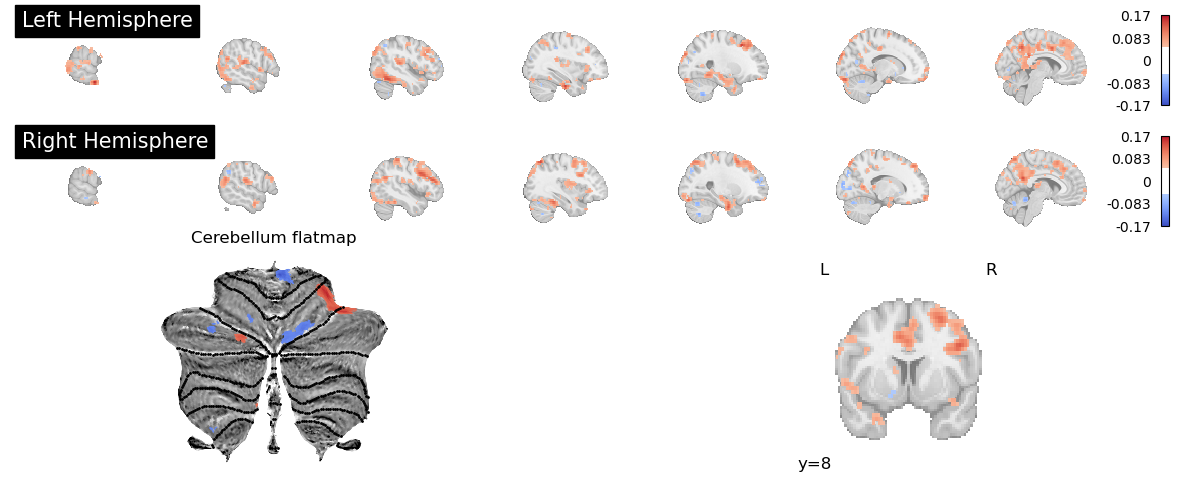

In [54]:
filename = outp_dir+'/group_results/'+'all_ppi_task-social_region08_all_win_V_region08_all_loss_group'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

# Summary

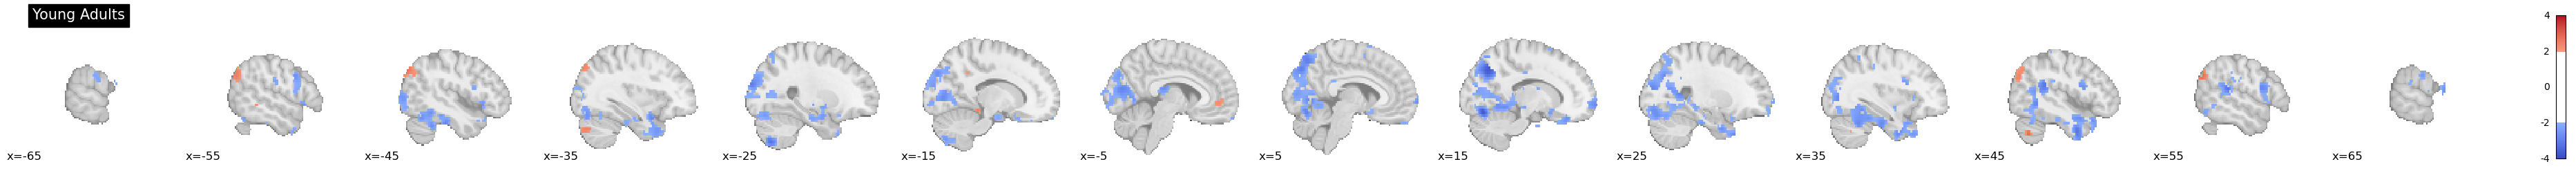

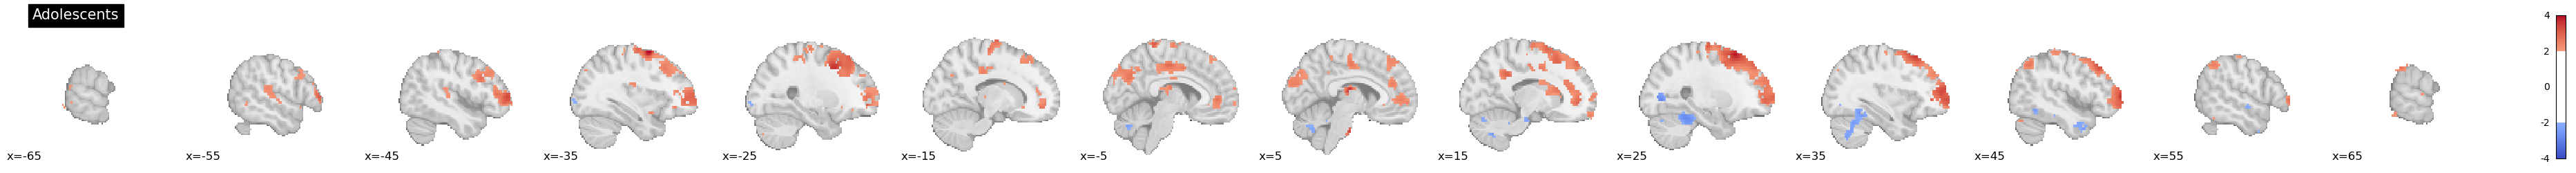

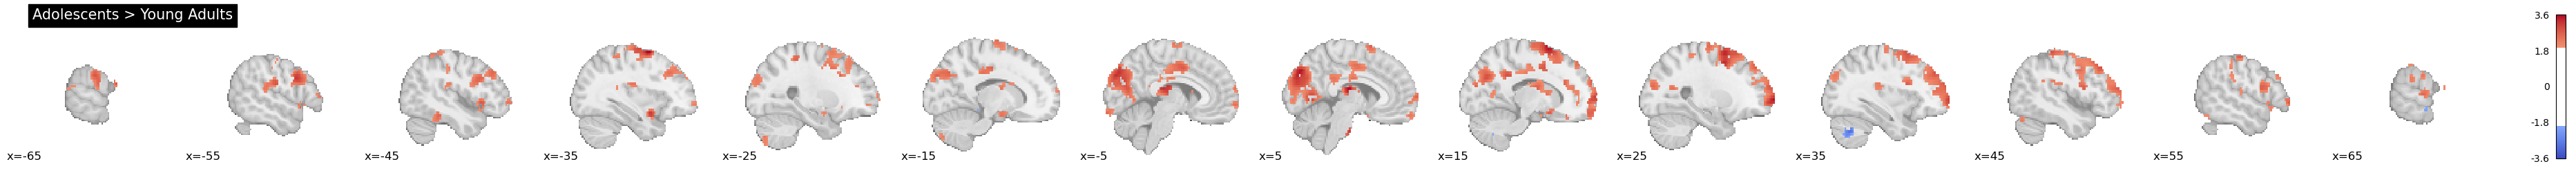

In [45]:
plot_stat_contours('zmap_ppi_region08_adult', mc='fdr', mc_alpha=0.05, thresh=2, view='straight', 
                   title='Young Adults')
plot_stat_contours('zmap_ppi_region08_adole', mc='fdr', mc_alpha=0.05, thresh=2, view='straight', 
                   title='Adolescents')
plot_stat_contours('zmap_ppi_region08_adoleVadult', mc='fdr', mc_alpha=0.05, thresh=2, view='straight', 
                   title='Adolescents > Young Adults')

Overall, there were no significant results after multiple comparisons correction (FDR < .05). However, some interesting trends hint at differences in Crus I/II connectivity with the cerebrum between adolescents and young adults for win trials over loss trials of the task. Connectivity between Crus I/II and the dlPFC, striatum, and early visual cortex is greater in adolescents than in young adults. This connectivity does not change significantly, when account for activity in either the reward or social networks.